# Importing the libraries

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Data loading & preprocessing

In [2]:
# Load the dataset (change paths as needed)
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', names=['movie_id', 'title'], usecols=[0, 1], encoding='latin-1')

In [3]:
# Merge ratings with movie titles
data = pd.merge(ratings, movies, on='movie_id')

In [4]:
# Create a user-movie matrix
user_movie_matrix = data.pivot_table(index='user_id', columns='title', values='rating')
user_movie_matrix.fillna(0, inplace=True)

# EDA 

In [5]:
user_movie_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [7]:
data.dtypes

user_id       int64
movie_id      int64
rating        int64
timestamp     int64
title        object
dtype: object

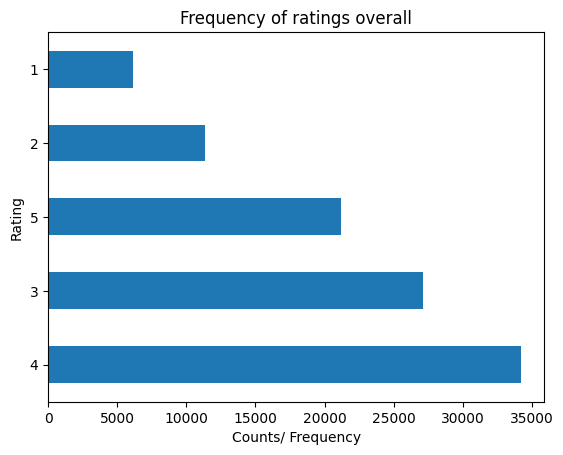

In [8]:
data['rating'].value_counts().plot(kind='barh')
plt.title('Frequency of ratings overall')
plt.xlabel('Counts/ Frequency')
plt.ylabel('Rating')
plt.show()

In [9]:
data['user_id'].nunique()

943

In [10]:
data.shape

(100000, 5)

In [11]:
data.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'title'], dtype='object')

In [12]:
data.size

500000

In [13]:
data.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100000 non-null  int64 
 1   movie_id   100000 non-null  int64 
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  int64 
 4   title      100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


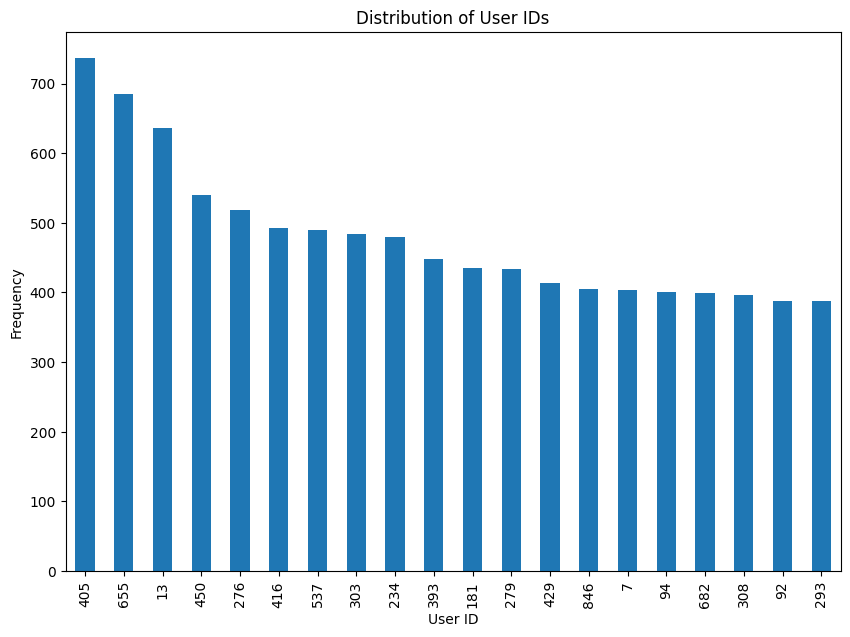

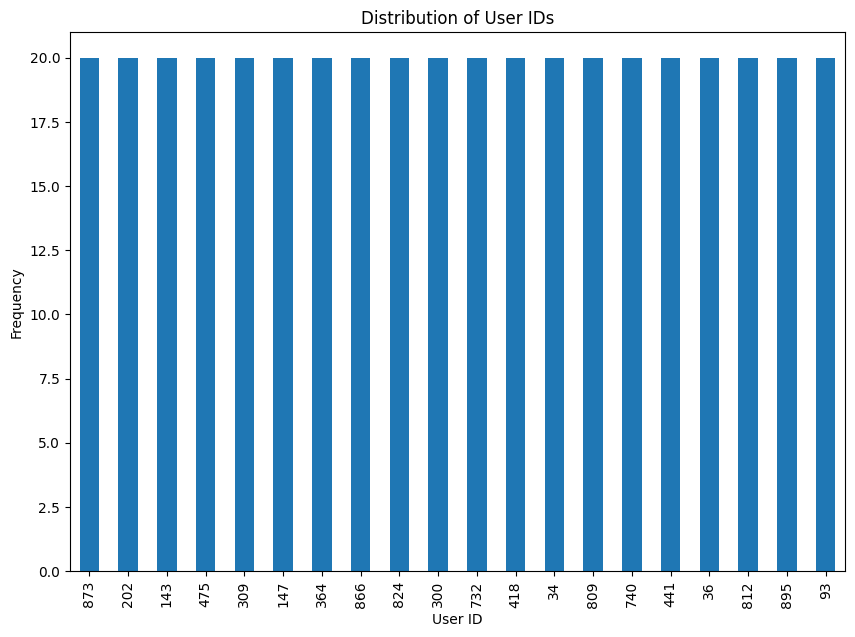

In [15]:
user_counts_Top_20 = data['user_id'].value_counts()[:20]
user_counts_Last_20 = data['user_id'].value_counts()[-20:]

# Plotting bar chart 
user_counts_Top_20.plot(kind='bar', figsize=(10, 7))

# Adding titles and labels
plt.title('Distribution of User IDs')
plt.xlabel('User ID')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

user_counts_Last_20.plot(kind='bar', figsize=(10, 7))

# Adding titles and labels
plt.title('Distribution of User IDs')
plt.xlabel('User ID')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Implement Recommendation Logic

In [16]:
# Compute cosine similarity between movies
movie_similarity_first = cosine_similarity(user_movie_matrix.T)

In [18]:
movie_similarity_first.shape

(1664, 1664)

In [20]:
movie_similarity_first

array([[1.        , 0.        , 0.02456069, ..., 0.        , 0.11020775,
        0.        ],
       [0.        , 1.        , 0.01413884, ..., 0.07963978, 0.04229549,
        0.        ],
       [0.02456069, 0.01413884, 1.        , ..., 0.17215501, 0.04571447,
        0.        ],
       ...,
       [0.        , 0.07963978, 0.17215501, ..., 1.        , 0.        ,
        0.        ],
       [0.11020775, 0.04229549, 0.04571447, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [23]:
# Convert to a DataFrame for easier manipulation
movie_similarity_df = pd.DataFrame(movie_similarity_first, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

In [24]:
movie_similarity_df.head().iloc[:, :5]

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997)
title,,,,,
'Til There Was You (1997),1.000000,0.000000,0.024561,0.099561,0.185236
1-900 (1994),0.000000,1.000000,0.014139,0.009294,0.007354
101 Dalmatians (1996),0.024561,0.014139,1.000000,0.167006,0.061105
12 Angry Men (1957),0.099561,0.009294,0.167006,1.000000,0.056822
187 (1997),0.185236,0.007354,0.061105,0.056822,1.000000


In [25]:
# Recommendation function
def recommend_movies(movie_title, n_recommendations=5):
    if movie_title not in movie_similarity_df.index:
        return f"Movie '{movie_title}' not found in dataset."
    
    # Get similar movies
    similar_movies = movie_similarity_df[movie_title].sort_values(ascending=False)[1:n_recommendations+1]
    return similar_movies

In [26]:
# Example Usage
movie_to_recommend = 'Toy Story (1995)' 
recommendations = recommend_movies(movie_to_recommend, n_recommendations=5)
print(f"Movies similar to '{movie_to_recommend}':\n{recommendations}")

Movies similar to 'Toy Story (1995)':
title
Star Wars (1977)                 0.734572
Return of the Jedi (1983)        0.699925
Independence Day (ID4) (1996)    0.689786
Rock, The (1996)                 0.664555
Mission: Impossible (1996)       0.641322
Name: Toy Story (1995), dtype: float64


In [27]:
# Example Usage
movie_to_recommend = 'Star Wars (1977)' 
recommendations = recommend_movies(movie_to_recommend, n_recommendations=5)
print(f"Movies similar to '{movie_to_recommend}':\n{recommendations}")

Movies similar to 'Star Wars (1977)':
title
Return of the Jedi (1983)          0.884476
Raiders of the Lost Ark (1981)     0.764885
Empire Strikes Back, The (1980)    0.749819
Toy Story (1995)                   0.734572
Godfather, The (1972)              0.697332
Name: Star Wars (1977), dtype: float64


# Improving Recommendation system

In [28]:
# Create pivot table
movie_user_matrix = data.pivot_table(index='user_id', columns='title', values='rating')

In [29]:
# Fill missing values with movie averages
movie_user_matrix = movie_user_matrix.fillna(movie_user_matrix.mean(axis=0))

In [30]:
movie_user_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,2.333333,2.6,2.000000,5.000,3.02439,3.225806,3.0,4.000000,1.0,4.050847,...,1.0,3.285714,3.0,5.000,3.000000,2.772727,3.341463,2.166667,4.000000,3.0
2,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
3,2.333333,2.6,2.908257,4.344,2.00000,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
4,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
5,2.333333,2.6,2.000000,4.344,3.02439,3.225806,3.5,4.000000,1.0,4.050847,...,1.0,3.285714,3.0,4.000,3.207921,2.772727,3.341463,2.166667,4.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
940,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0
941,2.333333,2.6,2.908257,4.344,3.02439,3.225806,3.5,3.969112,1.0,4.050847,...,1.0,3.285714,3.0,3.945,3.207921,2.772727,3.341463,2.166667,3.444444,3.0


In [31]:
# Normalize ratings
normalized_matrix = movie_user_matrix.subtract(movie_user_matrix.mean(axis=1), axis=0)

In [32]:
normalized_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.757217,-0.490550,-1.090550,1.909450,-0.066160,0.135256,-0.090550,0.909450,-2.090550,0.960297,...,-2.090550,0.195164,-0.090550,1.909450,-0.090550,-0.317823,0.250913,-0.923884,0.909450,-0.090550
2,-0.747814,-0.481147,-0.172891,1.262853,-0.056757,0.144659,0.418853,0.887965,-2.081147,0.969700,...,-2.081147,0.204567,-0.081147,0.863853,0.126773,-0.308420,0.260316,-0.914481,0.363297,-0.081147
3,-0.727529,-0.460862,-0.152605,1.283138,-1.060862,0.164944,0.439138,0.908250,-2.060862,0.989985,...,-2.060862,0.224852,-0.060862,0.884138,0.147058,-0.288135,0.280601,-0.894196,0.383582,-0.060862
4,-0.757091,-0.490424,-0.182168,1.253576,-0.066034,0.135382,0.409576,0.878687,-2.090424,0.960423,...,-2.090424,0.195290,-0.090424,0.854576,0.117496,-0.317697,0.251039,-0.923758,0.354020,-0.090424
5,-0.705689,-0.439022,-1.039022,1.304978,-0.014632,0.186784,0.460978,0.960978,-2.039022,1.011825,...,-2.039022,0.246692,-0.039022,0.960978,0.168898,-0.266295,0.302441,-0.872356,0.960978,-0.039022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,-0.775437,-0.508770,-0.200513,1.235230,-0.084380,0.117036,0.391230,0.860342,-2.108770,0.942077,...,-2.108770,0.176944,-0.108770,0.836230,0.099151,-0.336043,0.232693,-0.942103,0.335674,-0.108770
940,-0.725384,-0.458717,-0.150461,1.285283,-0.034327,0.167089,0.441283,0.910394,-2.058717,0.992130,...,-2.058717,0.226997,-0.058717,0.886283,0.149203,-0.285990,0.282746,-0.892051,0.385727,-0.058717
941,-0.748494,-0.481828,-0.173571,1.262172,-0.057438,0.143979,0.418172,0.887284,-2.081828,0.969020,...,-2.081828,0.203887,-0.081828,0.863172,0.126093,-0.309100,0.259636,-0.915161,0.362617,-0.081828


In [33]:
# Compute cosine similarity
movie_similarity = cosine_similarity(normalized_matrix.T)
similarity_df = pd.DataFrame(movie_similarity, index=movie_user_matrix.columns, columns=movie_user_matrix.columns)

In [34]:
similarity_df.head().iloc[:, :5]

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997)
title,,,,,
'Til There Was You (1997),1.000000,0.973134,0.411854,-0.972741,0.212828
1-900 (1994),0.973134,1.000000,0.403389,-0.961739,0.226524
101 Dalmatians (1996),0.411854,0.403389,1.000000,-0.425713,0.079043
12 Angry Men (1957),-0.972741,-0.961739,-0.425713,1.000000,-0.218151
187 (1997),0.212828,0.226524,0.079043,-0.218151,1.000000


In [35]:
# Function for recommendations
def recommend_movies(movie, n=5):
    if movie not in movie_similarity_df.index:
        return f"Movie '{movie_title}' not found in dataset."
         
    similar_movies = similarity_df[movie].sort_values(ascending=False)[1:n+1]
    return similar_movies

In [36]:
# Example Usage
movie_to_recommend = 'Toy Story (1995)' 
recommendations = recommend_movies('Toy Story (1995)', 5)
print(f"Movies similar to '{movie_to_recommend}':\n{recommendations}")

Movies similar to 'Toy Story (1995)':
title
Aiqing wansui (1994)                          0.782366
Great Day in Harlem, A (1994)                 0.782366
They Made Me a Criminal (1939)                0.782366
Marlene Dietrich: Shadow and Light (1996)     0.782366
Prefontaine (1997)                            0.782366
Name: Toy Story (1995), dtype: float64


<h4>It seems that the previous one was giving more relevant result, yet not perfect.</h4>

<b>Possible reasons</b>
> Normalize may result in over normalization which was not needed. <br/>
> Fill nan with average might not make sense.

<h3>We will stick with the previous model.</h3>

# Dumping the model

In [44]:
# Create 'models' directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save similarity matrix to a .pkl file
with open("models/similarity_matrix_first.pkl", "wb") as file:
    pickle.dump(movie_similarity_first, file)

print("Similarity matrix saved successfully!")

Similarity matrix saved successfully!


# Loading model for testing

In [47]:
movie_similarity_first.shape # Original matrix

(1664, 1664)

In [55]:
# Verify the saved similarity matrix
with open("models/similarity_matrix_first.pkl", "rb") as file:
    loaded_similarity_matrix = pickle.load(file)

print(loaded_similarity_matrix.shape)  # Ensure it matches your expectations
print(loaded_similarity_matrix)

(1664, 1664)
[[1.         0.         0.02456069 ... 0.         0.11020775 0.        ]
 [0.         1.         0.01413884 ... 0.07963978 0.04229549 0.        ]
 [0.02456069 0.01413884 1.         ... 0.17215501 0.04571447 0.        ]
 ...
 [0.         0.07963978 0.17215501 ... 1.         0.         0.        ]
 [0.11020775 0.04229549 0.04571447 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


# Dump the data file as csv

In [51]:
# Save movies DataFrame to CSV
data.to_csv("movies.csv", index=False)
print("Movies dataset saved as movies.csv")

Movies dataset saved as movies.csv


# Streamlit app

In [58]:
%%writefile app.py
import streamlit as st
import pickle
import pandas as pd
import os

# Load dumped similarity matrix
with open("models/similarity_matrix_first.pkl", "rb") as file:
    similarity_matrix = pickle.load(file)

# Load movie dataset
movies = pd.read_csv("dataset/movies.csv")  # Ensure this file is in the same directory
movie_titles = movies['title'].tolist()

# Streamlit App
st.set_page_config(page_title="Movie Recommendation System", layout="wide")

# Header and Description
st.title("🎥 Movie Recommendation System")
st.image("images/netflix-image.jpg", caption="Discover Your Next Favorite Movie!")
st.markdown("""
Welcome to the Movie Recommendation System!  
- **Model**: Cosine Similarity on Movie Ratings  
- **Working**: Provide a movie title, and we'll suggest similar movies based on ratings and user preferences.  
- **Dataset**: MovieLens  

### Input Format
- Enter the exact movie title as it appears in the dataset. For example:  
  - `"Kolya (1996)"`  
  - `"Toy Story (1995)"`  
  - `"Star Wars (1977)"` 
In other words, movie name with proper space, then space, open bracket, year, & lastly close bracket.

""")

# Input Section
st.subheader("Find Movies Similar to Your Favorite")
movie_name = st.text_input("Enter a movie name", placeholder="e.g., Kolya (1996)")

# Recommendation Logic
if st.button("Recommend"):
    if movie_name in movie_titles:
        # Get index of the movie
        movie_idx = movie_titles.index(movie_name)
        
        # Fetch similarity scores and recommend top 5
        similar_movies = sorted(
            list(enumerate(similarity_matrix[movie_idx])),
            key=lambda x: x[1],
            reverse=True
        )[1:6]  # Skip the first one as it's the input movie itself
        
        st.subheader(f"Movies similar to '{movie_name}':")
        for idx, score in similar_movies:
            st.write(f"- {movies.iloc[idx]['title']} (Similarity Score: {score:.2f})")
    else:
        st.error("Movie not found. Please check the spelling, input format (name, space, brackets, year) or try another movie.")


Overwriting app.py


# Conclusion:
<h3>In this project, we built a movie recommendation system using collaborative filtering with cosine similarity. By utilizing the "MovieLens" dataset, we first prepared the data, including handling missing values and scaling features. Then, we computed a similarity matrix between movies based on user ratings and leveraged this matrix to recommend movies similar to a given title. To enhance user experience, we created an interactive Streamlit app, where users can input a movie title and receive a list of recommended movies based on their similarity. This project demonstrates how basic recommendation algorithms can be implemented and provides a useful foundation for exploring more advanced recommendation systems using machine learning techniques.</h3>